In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torchviz import make_dot
import os

########################################################## 讀取CSV檔案
file_path = 'data/data_simulate_UE6.csv'  # 請替換為實際檔案路徑
df = pd.read_csv(file_path, header=None, names=['access_type', 'imsi', 'id', 'mcc', 'mnc', 'tac', 'timestamp'])

# 保留需要的三個欄位
selected_columns = ['imsi', 'tac', 'timestamp']
df = df[selected_columns]

# 將時間戳記轉換成Python的datetime對象
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 使用LabelEncoder將非數字的特徵轉換成數字
label_encoder = LabelEncoder()
df['imsi'] = label_encoder.fit_transform(df['imsi'])
df['tac'] = label_encoder.fit_transform(df['tac'])

# 查看編碼對應
encoding_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Encoding Mapping:")
print(encoding_mapping)

# 將資料按ID和時間戳記排序
df = df.sort_values(by=['imsi', 'timestamp'])
##########################################################
# define RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# 定義 create_sequences 函數，只選擇特定的 imsi 進行預測
def create_sequences(data, imsi, seq_length):
    data_imsi = data[data['imsi'] == imsi]
    
    # 檢查是否有足夠的資料建立序列
    if len(data_imsi) < seq_length + 1:
        print(f'length of data_imsi = {len(data_imsi)}')
        print(f'Not enough data for IMSI: {imsi}')
        return None, None
    
    sequences = []
    targets = []
    for i in range(len(data_imsi) - seq_length):
        seq = data_imsi.iloc[i:i+seq_length, [0, 1]].values  
        target = data_imsi.iloc[i+seq_length, 1]  

        # 檢查是否有 NaN 或 NaT 值，如果有，跳過這筆資料
        if pd.isna(seq).any() or pd.isna(target):
            continue

        sequences.append(seq)
        targets.append(target)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.long)

# 定義手動提供測試資料並預測的函數
def predict_next_tac(model, imsi, seq_length, test_data):
    with torch.no_grad():
        # 將 test_data 調整為正確的形狀
        input_seq = test_data.reshape(-1, seq_length, input_size)
        predicted_tac = torch.argmax(model(input_seq), dim=1).numpy()

    # 將預測的 TAC 解碼回原始的字串值
    predicted_tac_strings = label_encoder.inverse_transform(predicted_tac)

    print(f'預測的 TAC 為: {predicted_tac}')
    #print(f'解碼後的TAC序列: {predicted_tac_strings}')
########################################################## model
# 定義模型參數
input_size = 2  # 每個時間點的特徵數，這裡是兩個欄位
hidden_size = 10  # RNN的隱藏層大小
output_size = len(label_encoder.classes_)  # 預測的目標數，這裡是 TAC 的不同類別數

# 創建模型、損失函數和優化器
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # 交叉熵損失用於分類問題
optimizer = optim.Adam(model.parameters(), lr=0.1)

# 將資料轉換成模型可用的格式
seq_length = 1  # 時間序列的長度，可以根據實際情況調整
sequences, targets = create_sequences(df, imsi=0, seq_length=seq_length)  # 這裡的 imsi=0 代表選擇第一個 imsi 進行預測

# 分割資料集為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.3, random_state=42)
#X_train, y_train = sequences, targets
#X_test, y_test = None, None  # 留給後面手動提供測試資料

# 印出總共有多少筆training data、testing data
print(f'Total Training Data: {len(X_train)}')
#print(f'Total Testing Data: {len(X_test)}')
"""
# 印出所有training data和testing data
print("Training Data:")
print(X_train)
print(y_train)

print("Testing Data:")
print(X_test)
print(y_test)
"""
# 在訓練模型的迴圈中，記錄每個epoch的訓練損失和驗證損失
train_losses = []
val_losses = []

# 檢查權重檔案是否存在
weight_path = 'model_weights.pth'
if os.path.exists(weight_path):
    # 如果存在，載入之前的權重檔案
    model.load_state_dict(torch.load(weight_path))
    print(f'成功載入之前的權重檔案: {weight_path}')
else:
    print(f'找不到之前的權重檔案，將以新模型開始訓練')

# 訓練模型
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # 將 X_train 調整為正確的形狀
    input_seq = X_train.reshape(-1, seq_length, input_size)

    output = model(input_seq)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# 保存模型權重
weight_path = 'model_weights.pth'
torch.save(model.state_dict(), weight_path)

Encoding Mapping:
{0: 0, 1: 1, 2: 2, 3: 3}


C:\Users\11157\AppData\Local\Temp\ipykernel_32584\1523317228.py:80: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.long)


Total Training Data: 1040
成功載入之前的權重檔案: model_weights.pth
Epoch [100/1000], Loss: 0.3896837532520294
Epoch [200/1000], Loss: 0.3896764814853668
Epoch [300/1000], Loss: 0.3896719813346863
Epoch [400/1000], Loss: 0.38966885209083557
Epoch [500/1000], Loss: 0.38966676592826843
Epoch [600/1000], Loss: 0.38967496156692505
Epoch [700/1000], Loss: 0.3896637260913849
Epoch [800/1000], Loss: 0.38972124457359314
Epoch [900/1000], Loss: 0.3896629214286804
Epoch [1000/1000], Loss: 0.38966330885887146


In [2]:
# 預測資料

# 載入權重
model.load_state_dict(torch.load(weight_path))

# 將模型設為評估模式
model.eval()

# 在測試集上評估模型
with torch.no_grad():
    test_input_seq = X_test.reshape(-1, seq_length, input_size)
    test_output = model(test_input_seq)

    # 計算準確度
    predicted_labels = torch.argmax(test_output, dim=1)
    accuracy = (predicted_labels == y_test).float().mean()

    print(f'Test Accuracy: {accuracy.item()}')

# 手動提供測試資料
targeted_imsi = 0
manual_test_data = torch.tensor([[[0.0, 1.0]]], dtype=torch.float32)

# 預測下一個 TAC
predict_next_tac(model, imsi=targeted_imsi, seq_length=seq_length, test_data=manual_test_data)

Test Accuracy: 0.8680089712142944
預測的 TAC 為: [1]


用torchviz畫出模型的架構

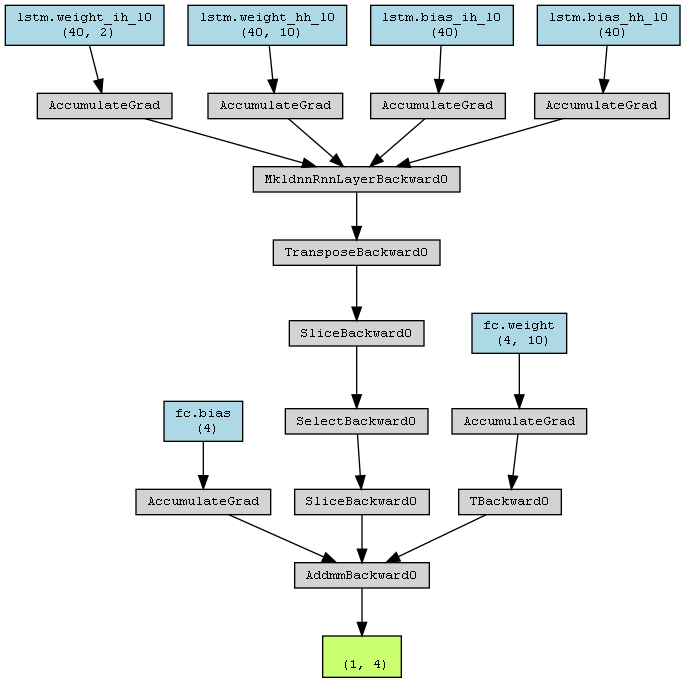

In [4]:
from torchviz import make_dot
from IPython.display import Image

# 定義一個虛擬的輸入
dummy_input = torch.randn(1, seq_length, input_size)

# 產生模型的可視化圖
model.eval()
output = model(dummy_input)
make_dot(output, params=dict(model.named_parameters())).render("LSTM_model", format="png")

Image(filename='LSTM_model.png')